In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import L0 modules
from l0.layers import L0Linear

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


This example demonstrates basic L0 regularization with linear models using simple gradient descent. We'll show how the L0 penalty directly controls sparsity and the number of active features.

In [3]:
# Create L0 regularized linear model
class L0LinearRegression(nn.Module):
    def __init__(self, n_features, init_sparsity=0.9):
        super().__init__()
        self.l0_linear = L0Linear(
            n_features, 1,
            bias=False,
            init_sparsity=init_sparsity,
            temperature=0.5
        )

    def forward(self, x):
        return self.l0_linear(x).squeeze()

    def get_l0_loss(self):
        return self.l0_linear.get_l0_penalty()

    def get_sparsity(self):
        return self.l0_linear.get_sparsity()

model = L0LinearRegression(n_features, init_sparsity=0.5).to(device)
print(f"Initial sparsity: {model.get_sparsity():.2%}")

Initial sparsity: 23.17%


In [ ]:
# Create a simple linear regression model with L0 regularization
class L0LinearRegression(nn.Module):
    """Linear regression with L0 regularization."""
    def __init__(self, n_features, init_sparsity=0.9):
        super().__init__()
        self.l0_linear = L0Linear(
            n_features, 1,
            bias=False,
            init_sparsity=init_sparsity,
            temperature=0.5
        )

    def forward(self, x):
        return self.l0_linear(x).squeeze()

    def get_l0_loss(self):
        return self.l0_linear.get_l0_penalty()

    def get_sparsity(self):
        return self.l0_linear.get_sparsity()

In [ ]:
# Generate synthetic sparse data
n_features = 100
n_informative = 20
n_samples = 500

# Create sparse ground truth
X = torch.randn(n_samples, n_features)
true_weights = torch.zeros(n_features)
true_weights[:n_informative] = torch.randn(n_informative) * 2
y = X @ true_weights + torch.randn(n_samples) * 0.1

# Split data
train_x, train_y = X[:400], y[:400]
test_x, test_y = X[400:], y[400:]

model = L0LinearRegression(n_features, init_sparsity=0.5).to(device)
print(f"Initial sparsity: {model.get_sparsity():.2%}")

In [ ]:
# Train the model
optimizer = optim.Adam(model.parameters(), lr=0.01)
l0_lambda = 0.001

losses = []
sparsities = []

for epoch in range(100):
    optimizer.zero_grad()

    # Forward pass
    pred = model(train_x.to(device))
    mse_loss = F.mse_loss(pred, train_y.to(device))
    l0_loss = model.get_l0_loss()
    total_loss = mse_loss + l0_lambda * l0_loss

    # Backward pass
    total_loss.backward()
    optimizer.step()

    # Track metrics
    losses.append(total_loss.item())
    sparsities.append(model.get_sparsity())

# Visualize training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(losses)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

ax2.plot(sparsities)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Sparsity')
ax2.set_title('Learned Sparsity')
ax2.grid(True)
ax2.axhline(y=(n_features-n_informative)/n_features, color='r', linestyle='--',
            label=f'True sparsity: {(n_features-n_informative)/n_features:.1%}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Final sparsity: {model.get_sparsity():.2%}")
print(f"True sparsity: {(n_features-n_informative)/n_features:.1%}")

L0 penalty= 0.0e+00: 35 active features, sparsity=29.5%, MSE=6.7351


L0 penalty= 1.0e-05: 36 active features, sparsity=28.0%, MSE=6.2577
L0 penalty= 1.0e-04: 36 active features, sparsity=27.1%, MSE=11.9122
L0 penalty= 1.0e-03: 37 active features, sparsity=25.6%, MSE=8.6586
L0 penalty= 1.0e-02: 36 active features, sparsity=27.4%, MSE=3.5160
L0 penalty= 1.0e-01: 35 active features, sparsity=28.7%, MSE=7.9384


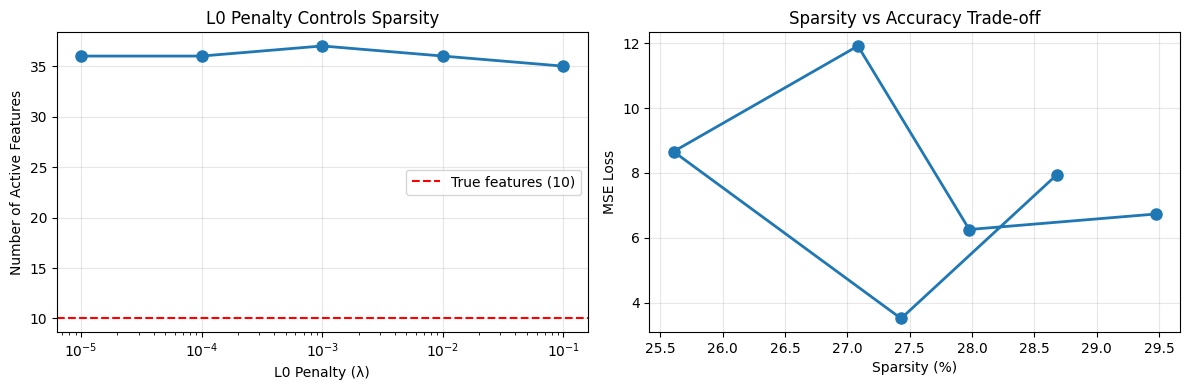


Key insight: Higher L0 penalty → Fewer active features → Higher sparsity
Ground truth had 10 important features out of 50 total


In [7]:
# Experiment: How does L0 penalty affect sparsity?
# We'll train multiple models with different L0 penalties

import matplotlib.pyplot as plt

# Generate sparse ground truth data
n_features = 50
n_samples = 200
n_true_features = 10  # Only 10 features actually matter

# Create sparse ground truth weights
true_weights = torch.zeros(n_features)
true_weights[:n_true_features] = torch.randn(n_true_features) * 2

# Generate data
X = torch.randn(n_samples, n_features)
y = X @ true_weights + torch.randn(n_samples) * 0.1

# Train models with different L0 penalties
l0_penalties = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
results = []

for l0_lambda in l0_penalties:
    # Create model with simple gradient descent
    model = L0Linear(n_features, 1, bias=False, init_sparsity=0.5, temperature=0.5)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Train
    for epoch in range(200):
        optimizer.zero_grad()
        pred = model(X).squeeze()
        mse = F.mse_loss(pred, y)
        l0_penalty = model.get_l0_penalty()
        loss = mse + l0_lambda * l0_penalty
        loss.backward()
        optimizer.step()

    # Record results
    final_sparsity = model.get_sparsity()
    n_active = int((1 - final_sparsity) * n_features)
    final_mse = F.mse_loss(model(X).squeeze(), y).item()

    results.append({
        'l0_lambda': l0_lambda,
        'sparsity': final_sparsity,
        'n_active': n_active,
        'mse': final_mse
    })

    print(f"L0 penalty={l0_lambda:8.1e}: {n_active:2d} active features, "
          f"sparsity={final_sparsity:.1%}, MSE={final_mse:.4f}")

# Visualize the relationship
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Number of active features vs L0 penalty
l0_vals = [r['l0_lambda'] for r in results[1:]]  # Skip 0
n_active_vals = [r['n_active'] for r in results[1:]]
ax1.semilogx(l0_vals, n_active_vals, 'o-', linewidth=2, markersize=8)
ax1.axhline(y=n_true_features, color='r', linestyle='--', label=f'True features ({n_true_features})')
ax1.set_xlabel('L0 Penalty (λ)')
ax1.set_ylabel('Number of Active Features')
ax1.set_title('L0 Penalty Controls Sparsity')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Trade-off between sparsity and accuracy
sparsity_vals = [r['sparsity'] for r in results]
mse_vals = [r['mse'] for r in results]
ax2.plot([100*s for s in sparsity_vals], mse_vals, 'o-', linewidth=2, markersize=8)
ax2.set_xlabel('Sparsity (%)')
ax2.set_ylabel('MSE Loss')
ax2.set_title('Sparsity vs Accuracy Trade-off')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey insight: Higher L0 penalty → Fewer active features → Higher sparsity")
print(f"Ground truth had {n_true_features} important features out of {n_features} total")

Next, let's demonstrate L0 regularization with simple gradient descent (no neural network layers) to show how the L0 penalty directly controls sparsity: